In [ ]:
# 단계 1: 폰트 설치
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null



fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설치

# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [1]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설치

In [2]:
import pandas as pd
import numpy as np
from typing import List, Optional, Dict, Tuple
from pathlib import Path

class DataProcessor:
    """쌀 생산량과 기후 데이터를 처리하는 클래스"""

    CLIMATE_COLUMNS = {
        'annual': {
            '평균기온(°C)합계': '평균기온(°C)',
            '강수량(mm)': '합계 강수량(mm)',
            '평균 상대습도(%)합계': '평균 상대습도(%)',
            '일조시간(hr)': '합계 일조시간(hr)'
        },
        'monthly': {
            '평균기온(°C)': '평균기온(°C)',
            '평균상대습도(%)': '평균 상대습도(%)',
            '월합강수량(00~24h만)(mm)': '합계 강수량(mm)',
            '합계 일조시간(hr)': '합계 일조시간(hr)'
        }
    }

    REGION_MAPPING = {
        # 전라남도 지역
        '목포': '전라남도', '여수': '전라남도', '순천': '전라남도',
        '완도': '전라남도', '진도(첨찰산)': '전라남도', '진도군': '전라남도',
        '해남': '전라남도', '고흥': '전라남도', '광양시': '전라남도',
        '보성군': '전라남도', '강진군': '전라남도', '장흥': '전라남도',

        # 충청남도 지역
        '서산': '충청남도', '천안': '충청남도', '보령': '충청남도',
        '부여': '충청남도', '홍성': '충청남도',

        # 전라북도 지역
        '전주': '전라북도', '군산': '전라북도', '부안': '전라북도',
        '임실': '전라북도', '정읍': '전라북도', '남원': '전라북도',
        '장수': '전라북도', '고창군': '전라북도', '순창군': '전라북도',

        # 경상북도 지역
        '포항': '경상북도', '안동': '경상북도', '상주': '경상북도',
        '울진': '경상북도', '봉화': '경상북도', '영주': '경상북도',
        '문경': '경상북도', '청송군': '경상북도', '영덕': '경상북도',
        '의성': '경상북도', '구미': '경상북도', '영천': '경상북도',
        '경주시': '경상북도'
    }

    def __init__(self, target_regions: List[str]):
        self.target_regions = target_regions

    def fill_missing_years(self, df: pd.DataFrame, start_year: int = 2008, end_year: int = 2023) -> pd.DataFrame:
        """
        2008-2023년 범위의 데이터를 채우는 함수
        누락된 연도의 데이터는 해당 지역의 평균값으로 채움
        월별 데이터('YYYY-MM'형식)와 연간 데이터('YYYY'형식) 모두 처리
        지점과 지점명은 원본 매핑 유지
        """
        climate_columns = ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)', '합계 일조시간(hr)']
        result_df = []

        # 일시 컬럼이 월별 데이터(YYYY-MM) 형식인지 확인
        is_monthly = isinstance(df['일시'].iloc[0], str) and '-' in str(df['일시'].iloc[0])

        for location in df['지점명'].unique():
            # 해당 지역의 데이터만 필터링
            location_data = df[df['지점명'] == location].copy()

            # 해당 지점의 지점번호 가져오기
            location_code = location_data['지점'].iloc[0]

            if is_monthly:
                # 월별 데이터 처리
                existing_dates = location_data['일시'].unique()
                all_dates = []
                for year in range(start_year, end_year + 1):
                    for month in range(1, 13):
                        all_dates.append(f"{year}-{month:02d}")

                # 해당 지역의 각 기후 지표 평균 계산 (월별)
                location_means = {}
                for col in climate_columns:
                    if col in location_data.columns:
                        # 각 월별로 평균 계산
                        monthly_means = {}
                        for month in range(1, 13):
                            month_data = location_data[location_data['일시'].str.endswith(f'-{month:02d}')][col]
                            if not month_data.empty:
                                monthly_means[month] = month_data.mean()
                            else:
                                monthly_means[month] = location_data[col].mean()
                        location_means[col] = monthly_means

                # 누락된 날짜에 대한 데이터 생성
                missing_dates = [date for date in all_dates if date not in existing_dates]
                for date in missing_dates:
                    year, month = map(int, date.split('-'))
                    new_row = {
                        '지점': location_code,  # 정수형 지점 코드 유지
                        '지점명': location,
                        '일시': date
                    }
                    for col in climate_columns:
                        if col in location_data.columns:
                            new_row[col] = location_means[col][month]
                    result_df.append(new_row)
            else:
                # 연간 데이터 처리
                existing_years = location_data['일시'].astype(int).unique()
                all_years = list(range(start_year, end_year + 1))

                # 해당 지역의 각 기후 지표 평균 계산
                location_means = {
                    col: location_data[col].mean()
                    for col in climate_columns
                    if col in location_data.columns
                }

                # 누락된 연도에 대한 데이터 생성
                missing_years = [year for year in all_years if year not in existing_years]
                for year in missing_years:
                    new_row = {
                        '지점': location_code,  # 정수형 지점 코드 유지
                        '지점명': location,
                        '일시': year,
                        **location_means
                    }
                    result_df.append(new_row)

            # 기존 데이터도 결과에 추가
            result_df.extend(location_data.to_dict('records'))

        # 결과를 DataFrame으로 변환
        result_df = pd.DataFrame(result_df)

        # 지점을 정수형으로 변환
        result_df['지점'] = result_df['지점'].astype(int)

        # 정렬 및 인덱스 재설정
        result_df = result_df.sort_values(['지점명', '일시']).reset_index(drop=True)

        # 숫자형 컬럼들 반올림
        for col in climate_columns:
            if col in result_df.columns:
                result_df[col] = result_df[col].round(1)

        return result_df

    def process_rice_data(self, file_path: Path, output_path: Optional[Path] = None) -> pd.DataFrame:
        """쌀 생산량 데이터 처리"""
        try:
            raw_data = pd.read_excel(file_path)
        except Exception as e:
            raise ValueError(f"Excel 파일 읽기 실패: {str(e)}")

        years = [int(col) for col in raw_data.columns[1:] if str(col).isdigit()]
        unique_years = sorted(set(years))

        restructured_data = []
        for idx, row in raw_data.iloc[2:].iterrows():
            region_name = row.iloc[0]
            for i, year in enumerate(unique_years):
                area_idx = i * 2 + 1
                prod_idx = i * 2 + 2

                try:
                    area = self._convert_to_float(row.iloc[area_idx])
                    production = self._convert_to_float(row.iloc[prod_idx])

                    restructured_data.append({
                        '행정구역': region_name,
                        '일시': year,
                        '재배면적(ha)': area,
                        '생산량(톤)': production
                    })
                except (ValueError, IndexError):
                    continue

        processed_df = pd.DataFrame(restructured_data)
        processed_df = self._filter_and_sort_data(processed_df)

        if output_path:
            processed_df.to_excel(output_path, index=False)

        return processed_df

    def process_climate_data(
        self,
        annual_path: Path,
        monthly_path: Path
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """기후 데이터 처리"""
        annual_climate = pd.read_csv(annual_path, encoding='euc-kr')
        monthly_climate = pd.read_csv(monthly_path, encoding='euc-kr')

        # 시계열 데이터 완성
        annual_climate = self.fill_missing_years(annual_climate)
        monthly_climate = self.fill_missing_years(monthly_climate)

        # 컬럼명 변경 및 행정구역 정보 추가
        annual_climate = self._prepare_climate_data(annual_climate, 'annual')
        monthly_climate = self._prepare_climate_data(monthly_climate, 'monthly')

        # 결측치 처리
        annual_climate = self._fill_missing_climate_data(annual_climate)
        monthly_climate = self._fill_missing_climate_data(monthly_climate)

        return annual_climate, monthly_climate

    def _convert_to_float(self, value: any) -> float:
        """문자열이나 숫자를 float로 변환"""
        if pd.isna(value) or str(value) == '-':
            return 0.0
        return float(value)

    def _filter_and_sort_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """데이터 필터링 및 정렬"""
        if self.target_regions:
            df = df[df['행정구역'].isin(self.target_regions)]
        return df.sort_values(['행정구역', '일시']).reset_index(drop=True)

    def _prepare_climate_data(self, df: pd.DataFrame, data_type: str) -> pd.DataFrame:
        """기후 데이터 전처리"""
        df = df.rename(columns=self.CLIMATE_COLUMNS[data_type])
        df['행정구역'] = df['지점명'].map(self.REGION_MAPPING)
        return df[df['행정구역'].isin(self.target_regions)]

    def _fill_missing_climate_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """기후 데이터 결측치 처리"""
        climate_columns = ['평균기온(°C)', '합계 강수량(mm)',
                         '평균 상대습도(%)', '합계 일조시간(hr)']

        df_filled = df.copy()
        for col in climate_columns:
            if col in df.columns:
                df_filled[col] = pd.to_numeric(
                    df_filled[col].replace('', np.nan),
                    errors='coerce'
                )
                region_means = df_filled.groupby('행정구역')[col].transform('mean').round(1)
                df_filled[col] = df_filled[col].fillna(region_means).round(1)

        return df_filled

def main():
    """메인 실행 함수"""
    # 파일 경로 설정
    rice_file = Path('/content/시군별_논벼_생산량.xlsx')
    annual_climate_file = Path('/content/연간기후전체지역.csv')
    monthly_climate_file = Path('/content/월별기후전체지역.csv')

    # 타겟 지역 설정
    target_regions = ['전라남도', '충청남도', '전라북도', '경상북도']

    # 데이터 프로세서 인스턴스 생성
    processor = DataProcessor(target_regions)

    try:
        # 1. 쌀 생산량 데이터 처리
        rice_data = processor.process_rice_data(
            rice_file,
            Path('filtered_rice_production.xlsx')
        )

        # 2. 기후 데이터 처리
        annual_climate, monthly_climate = processor.process_climate_data(
            annual_climate_file,
            monthly_climate_file
        )

        # 3. 처리된 기후 데이터 저장
        annual_climate.to_csv('filtered_climate_annual_data.csv',
                            index=False, encoding='utf-8-sig')
        monthly_climate.to_csv('filtered_climate_monthly_data.csv',
                             index=False, encoding='utf-8-sig')

        print("모든 데이터 처리가 완료되었습니다.")

    except Exception as e:
        print(f"처리 중 오류가 발생했습니다: {str(e)}")

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


모든 데이터 처리가 완료되었습니다.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

class RiceProductionAnalyzer:
    def __init__(self):
        """데이터 로드 및 초기화"""
        self.rice_data = pd.read_excel('/content/filtered_rice_production.xlsx')
        self.climate_annual = pd.read_csv('/content/filtered_climate_annual_data.csv')
        self.climate_monthly = pd.read_csv('/content/filtered_climate_monthly_data.csv')
        self.processed_data = None
        self.prepare_data()

    def prepare_data(self):
        """데이터 전처리"""
        # 날짜 형식 통일
        self.climate_annual['일시'] = self.climate_annual['일시'].astype(int)
        self.climate_monthly['연도'] = self.climate_monthly['일시'].str.split('-').str[0].astype(int)
        self.climate_monthly['월'] = self.climate_monthly['일시'].str.split('-').str[1].astype(int)

        # 월별 기후 데이터 피봇
        monthly_pivot = self.climate_monthly.pivot_table(
            index=['행정구역', '연도'],
            columns='월',
            values=['평균기온(°C)', '평균 상대습도(%)', '합계 강수량(mm)', '합계 일조시간(hr)']
        ).reset_index()

        # 컬럼명 재구성
        monthly_pivot.columns = [
            f"{col[0]}_{col[1]}월" if isinstance(col, tuple) and col[1] != ""
            else col[0] for col in monthly_pivot.columns
        ]

        # 연도 컬럼명 변경
        monthly_pivot = monthly_pivot.rename(columns={'연도': '일시'})

        # 데이터 병합
        merged_data = pd.merge(
            self.rice_data,
            self.climate_annual[['행정구역', '일시', '평균기온(°C)', '합계 강수량(mm)',
                           '평균 상대습도(%)', '합계 일조시간(hr)']],
            on=['행정구역', '일시']
        )

        self.processed_data = pd.merge(
            merged_data,
            monthly_pivot,
            on=['행정구역', '일시']
        )


    def analyze_production_changes(self):
        """생산량 변화 분석"""
        # 지역별 기준년도(2008) 대비 생산량 변화율 계산
        pivot_data = self.rice_data.pivot(index='일시', columns='행정구역', values='생산량(톤)')
        change_ratio = (pivot_data / pivot_data.iloc[0] * 100 - 100).reset_index()

        # 2008년 기준 생산량 추출
        base_production = pivot_data.iloc[0].round(0)

        change_ratio_long = pd.melt(change_ratio,
                                  id_vars=['일시'],
                                  var_name='행정구역',
                                  value_name='변화율')

        # 범례 텍스트에 기준 생산량 추가
        custom_legend = {region: f"{region} (2008년: {base_production[region]:,.0f}톤)"
                        for region in pivot_data.columns}

        # 지역별 색상 정의
        colors = {
            '전라남도': '#1f77b4',  # 파란색
            '충청남도': '#2ca02c',  # 초록색
            '전라북도': '#ff7f0e',  # 주황색
            '경상북도': '#d62728'   # 빨간색
        }

        fig = px.line(change_ratio_long,
                    x='일시',
                    y='변화율',
                    color='행정구역',
                    title='2008년 대비 지역별 쌀 생산량 변화율 (%)',
                    labels={'변화율': '변화율 (%)', '일시': '연도'},
                    markers=True,
                    color_discrete_map=colors)

        # 범례 텍스트 업데이트
        for trace in fig.data:
            trace.name = custom_legend[trace.name]
            trace.line.width = 3  # 선 굵기 증가
            trace.marker.size = 8  # 마커 크기 증가

        fig.update_layout(
            height=600,
            width=1000,
            yaxis_tickformat='.1f',
            legend_title_text='지역 (2008년 기준 생산량)',
            template='plotly_white',  # 깔끔한 흰색 테마 적용
            font=dict(family='Noto Sans KR', size=12),  # 폰트 설정
            title=dict(
                font=dict(size=20, color='black'),
                x=0.5,  # 제목 중앙 정렬
                y=0.95
            ),
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="right",
                x=0.99,
                bgcolor='rgba(255, 255, 255, 0.8)'  # 반투명 흰색 배경
            ),
            plot_bgcolor='white',  # 플롯 배경색
            paper_bgcolor='white',  # 종이 배경색
            xaxis=dict(
                showgrid=True,
                gridwidth=1,
                gridcolor='lightgray',
                title_font=dict(size=14),
                tickfont=dict(size=12)
            ),
            yaxis=dict(
                showgrid=True,
                gridwidth=1,
                gridcolor='lightgray',
                title_font=dict(size=14),
                tickfont=dict(size=12)
            )
        )

        return fig

    def analyze_regional_comparison(self):
        """지역별 생산 특성 비교"""
        # 지역별 연도별 통계 계산
        stats_df = self.rice_data.groupby(['행정구역', '일시']).agg({
            '재배면적(ha)': 'sum',
            '생산량(톤)': 'sum'
        }).reset_index()

        # 단위면적당 생산량 계산 (톤/ha)
        stats_df['단위면적당생산량'] = (stats_df['생산량(톤)'] / stats_df['재배면적(ha)']).round(2)

        # 지역별 색상 정의
        region_colors = {
            '전라남도': '#1f77b4',
            '충청남도': '#ff7f0e',
            '전라북도': '#2ca02c',
            '경상북도': '#d62728'
        }

        fig = make_subplots(
            rows=1, cols=3,
            subplot_titles=('지역별 재배면적 (ha)',
                          '지역별 총 생산량 (톤)',
                          '지역별 단위면적당 생산량 (톤/ha)')
        )

        measures = ['재배면적(ha)', '생산량(톤)', '단위면적당생산량']
        for i, measure in enumerate(measures, 1):
            for region in stats_df['행정구역'].unique():
                region_data = stats_df[stats_df['행정구역'] == region]
                fig.add_trace(
                    go.Box(
                        y=region_data[measure],
                        name=region,
                        boxpoints='all',
                        pointpos=0,
                        marker_color=region_colors[region],
                        line_color=region_colors[region],
                        showlegend=(i == 1)
                    ),
                    row=1, col=i
                )

        fig.update_layout(
            height=600,
            width=1500,
            title_text="지역별 쌀 생산 특성 비교 (2008-2023)",
            showlegend=True
        )

        # y축 레이블 업데이트
        fig.update_yaxes(title_text="재배면적 (ha)", row=1, col=1)
        fig.update_yaxes(title_text="총 생산량 (톤)", row=1, col=2)
        fig.update_yaxes(title_text="단위면적당 생산량 (톤/ha)", row=1, col=3)

        return fig


    def analyze_climate_vulnerability(self):
        """지역별 기후 취약성 분석"""
        # Plotly를 사용한 히트맵 생성을 위한 준비
        climate_vars = ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)', '합계 일조시간(hr)']
        vulnerability_metrics = {}

        for region in self.processed_data['행정구역'].unique():
            region_data = self.processed_data[self.processed_data['행정구역'] == region]  # 이 부분이 수정됨

            # 각 기후 변수의 변동계수(CV) 계산
            cv_metrics = {}
            for var in climate_vars:
                cv = region_data[var].std() / region_data[var].mean()
                cv_metrics[f'{var}_CV'] = cv

            # 생산량 변동성
            production_cv = region_data['생산량(톤)'].std() / region_data['생산량(톤)'].mean()
            cv_metrics['생산량_CV'] = production_cv

            vulnerability_metrics[region] = cv_metrics

        vulnerability_df = pd.DataFrame(vulnerability_metrics).T

        # Plotly 히트맵 생성
        fig = go.Figure(data=go.Heatmap(
            z=vulnerability_df.values,
            x=vulnerability_df.columns,
            y=vulnerability_df.index,
            text=np.round(vulnerability_df.values, 3),
            texttemplate='%{text}',
            textfont={"size": 10},
            hoverongaps=False,
            colorscale='YlOrRd',
            colorbar=dict(title='변동계수(CV)'),
        ))

        # 레이아웃 업데이트
        fig.update_layout(
            title='지역별 기후 취약성 지표 (변동계수 기반)',
            xaxis_title='기후 변수',
            yaxis_title='지역',
            width=1000,
            height=600,
        )

        return fig, vulnerability_df


#############################
################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################
###################################################################################################################################################################################################
    def analyze_optimal_conditions(self):
       """지역별 최적 재배 조건 분석"""
       climate_vars = ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)', '합계 일조시간(hr)']
       optimal_conditions = {}

       for region in self.processed_data['행정구역'].unique():
           # 각 지역별로 상위 20% 데이터 추출
           region_data = self.processed_data[self.processed_data['행정구역'] == region]
           threshold = region_data['생산량(톤)'].quantile(0.8)
           region_optimal = region_data[region_data['생산량(톤)'] >= threshold]

           conditions = {}
           for var in climate_vars:
               conditions[f'{var}_범위'] = {
                   '최소': region_optimal[var].min(),
                   '최대': region_optimal[var].max(),
                   '평균': region_optimal[var].mean()
               }

           optimal_conditions[region] = conditions

       # 서브플롯 생성 (가로 배치)
       fig = make_subplots(
           rows=1,
           cols=4,
           subplot_titles=[f'<b>{var}</b>' for var in climate_vars],
           horizontal_spacing=0.08  # 서브플롯 간격 늘림
       )

       # 지역별 색상 정의 - 더 세련된 색상으로 변경
       region_colors = {
           '전라남도': '#3498db',  # 밝은 파란색
           '충청남도': '#2ecc71',  # 밝은 초록색
           '전라북도': '#f1c40f',  # 밝은 노란색
           '경상북도': '#e74c3c'   # 밝은 빨간색
       }

       # 각 기후 변수별 바 차트 추가
       for idx, var in enumerate(climate_vars, 1):
           # 평균값 데이터 준비
           regions = []
           means = []
           mins = []
           maxs = []
           colors = []

           for region in optimal_conditions.keys():
               regions.append(region)
               means.append(optimal_conditions[region][f'{var}_범위']['평균'])
               mins.append(optimal_conditions[region][f'{var}_범위']['최소'])
               maxs.append(optimal_conditions[region][f'{var}_범위']['최대'])
               colors.append(region_colors[region])

           # 바 차트 추가
           fig.add_trace(
               go.Bar(
                   name=var,
                   y=regions,
                   x=means,
                   error_x=dict(
                       type='data',
                       symmetric=False,
                       array=[max-mean for max, mean in zip(maxs, means)],
                       arrayminus=[mean-min for min, mean in zip(mins, means)],
                       color='rgba(0,0,0,0.2)',  # 더 투명한 오차 막대
                       thickness=1.5,
                       width=10
                   ),
                   text=[f'{mean:.1f}' for mean in means],  # 간단한 텍스트 표시
                   textposition='auto',
                   marker=dict(
                       color=colors,
                       line=dict(width=1, color='#ffffff')  # 흰색 테두리 추가
                   ),
                   showlegend=False,
                   orientation='h',
                   hovertemplate='<b>%{y}</b><br>' +
                               f'{var}: ' + '%{x:.1f}<br>' +
                               '최소: %{customdata[0]:.1f}<br>' +
                               '최대: %{customdata[1]:.1f}<br>' +
                               '<extra></extra>',
                   customdata=list(zip(mins, maxs))  # 호버 데이터 추가
               ),
               row=1,
               col=idx
           )

           # 축 레이블 업데이트
           fig.update_xaxes(
               title=dict(
                   text=var,
                   font=dict(size=12, color='#2c3e50')  # 진한 회색으로 변경
               ),
               tickfont=dict(size=10),
               showgrid=True,
               gridwidth=1,
               gridcolor='rgba(189, 195, 199, 0.4)',  # 연한 그리드
               row=1,
               col=idx
           )

           fig.update_yaxes(
               tickfont=dict(size=12, color='#2c3e50'),  # 진한 회색으로 변경
               showgrid=False,
               row=1,
               col=idx
           )

       # 레이아웃 업데이트
       fig.update_layout(
           height=350,  # 높이 조정
           width=1500,
           title=dict(
               text='지역별 최적 기후 조건 분석 (상위 20% 생산량 기준)',
               x=0.5,
               font=dict(size=20, color='#2c3e50', family='Noto Sans KR')
           ),
           showlegend=False,
           template='plotly_white',
           font=dict(family='Noto Sans KR'),
           plot_bgcolor='white',
           paper_bgcolor='white',
           margin=dict(t=100, b=50, l=50, r=50),
           bargap=0.2,  # 막대 사이 간격 조정
       )

       # 서브플롯 제목 스타일 업데이트
       for i in fig['layout']['annotations']:
           i['font'] = dict(size=14, color='#2c3e50', family='Noto Sans KR')

       return fig, optimal_conditions

################################################################################################################
################################################################################################################

    def run_all_analyses(self):
        """모든 분석 실행"""

        print("\n2. 생산량 변화 분석 중...")
        fig_changes = self.analyze_production_changes()
        fig_changes.show()

        print("\n3. 지역별 생산 특성 비교 중...")
        fig_comparison = self.analyze_regional_comparison()
        fig_comparison.show()

        print("\n5. 기후 취약성 분석 중...")
        fig_vulnerability, vulnerability_df = self.analyze_climate_vulnerability()
        fig_vulnerability.show()

        print("\n6. 최적 재배 조건 분석 중...")
        fig_optimal, optimal_conditions = self.analyze_optimal_conditions()
        fig_optimal.show()


        print("\n분석이 완료되었습니다.")

def main():
    """메인 함수"""
    # 필요한 패키지 설치
    print("필요한 패키지를 설치합니다...")
    try:
        import plotly
    except ImportError:
        !pip install plotly

    try:
        import xgboost
    except ImportError:
        !pip install xgboost

    # 분석 실행
    print("\n분석을 시작합니다...")
    analyzer = RiceProductionAnalyzer()
    analyzer.run_all_analyses()

if __name__ == "__main__":
    main()

필요한 패키지를 설치합니다...

분석을 시작합니다...

2. 생산량 변화 분석 중...



3. 지역별 생산 특성 비교 중...



5. 기후 취약성 분석 중...



6. 최적 재배 조건 분석 중...



분석이 완료되었습니다.


쌀 생산량 예측 모델 초기화

2023년 쌀 생산량 예측 시작...

2023년 예측 결과:
    행정구역   실제_생산량   예측_생산량           오차    오차율(%)
15  경상북도  501,248  508,569   7320.96875  1.460548
31  전라남도  736,694  772,100  35406.50000  4.806134
47  전라북도  582,477  570,607 -11870.37500 -2.037913
63  충청남도  726,989  680,809 -46180.12500 -6.352245

모델 평가 지표:
         RMSE         MAE      R2  Adjusted_R2    MAPE  Mean_Error  \
0  29919.5863  25194.4922  0.9092       1.0049  3.6642   3830.7578   

    Std_Error  Confidence_Interval  Error_Normality_p_value  Sample_Size  
0  29673.3372           29079.8704                      1.0            4  

오차의 정규성 검정 결과:
p-value: 1.0000
오차가 정규분포를 따릅니다 (신뢰할 만한 예측)

미래 생산량 예측 시작...

2024년 예측 (trend 시나리오):
   행정구역   예측_생산량    신뢰구간_하한    신뢰구간_상한   재배면적(ha)  단위면적당_생산량   실제_생산량  변화율(%)
0  경상북도  515,459  492789.71  538128.61   89127.98       5.78  501,248    2.84
1  전라남도  771,299  740429.15  802169.48  146574.25       5.26  736,694    4.70
2  전라북도  577,184  547687.86  606680.39  105144.86       5.49  

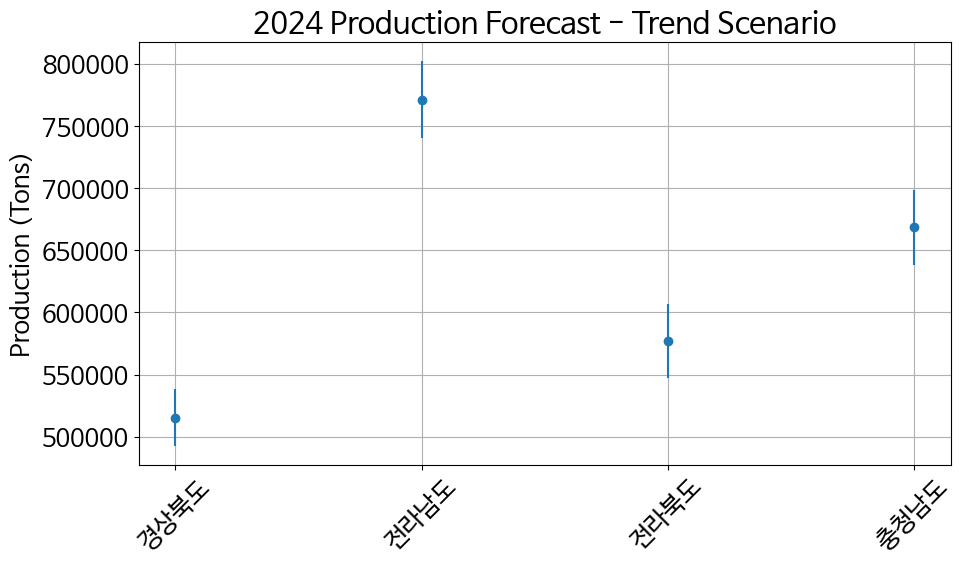


2024년 예측 (average 시나리오):
   행정구역   예측_생산량    신뢰구간_하한    신뢰구간_상한   재배면적(ha)  단위면적당_생산량   실제_생산량  변화율(%)
0  경상북도  515,459  492789.71  538128.61   89127.98       5.78  501,248    2.84
1  전라남도  771,299  740429.15  802169.48  146574.25       5.26  736,694    4.70
2  전라북도  577,184  547687.86  606680.39  105144.86       5.49  582,477   -0.91
3  충청남도  668,636  638595.29  698677.59  125087.66       5.35  726,989   -8.03


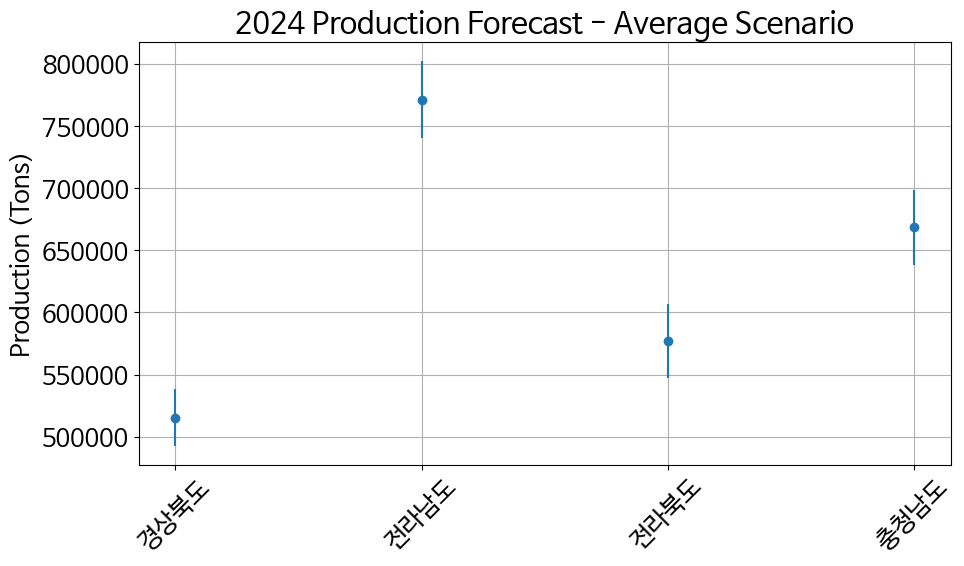


2024년 예측 (worst 시나리오):
   행정구역   예측_생산량    신뢰구간_하한    신뢰구간_상한   재배면적(ha)  단위면적당_생산량   실제_생산량  변화율(%)
0  경상북도  516,345  493675.43  539014.32   89127.98       5.79  501,248    3.01
1  전라남도  781,110  750240.15  811980.48  146574.25       5.33  736,694    6.03
2  전라북도  588,718  559221.67  618214.21  105144.86       5.60  582,477    1.07
3  충청남도  681,189  651147.48  711229.77  125087.66       5.45  726,989   -6.30


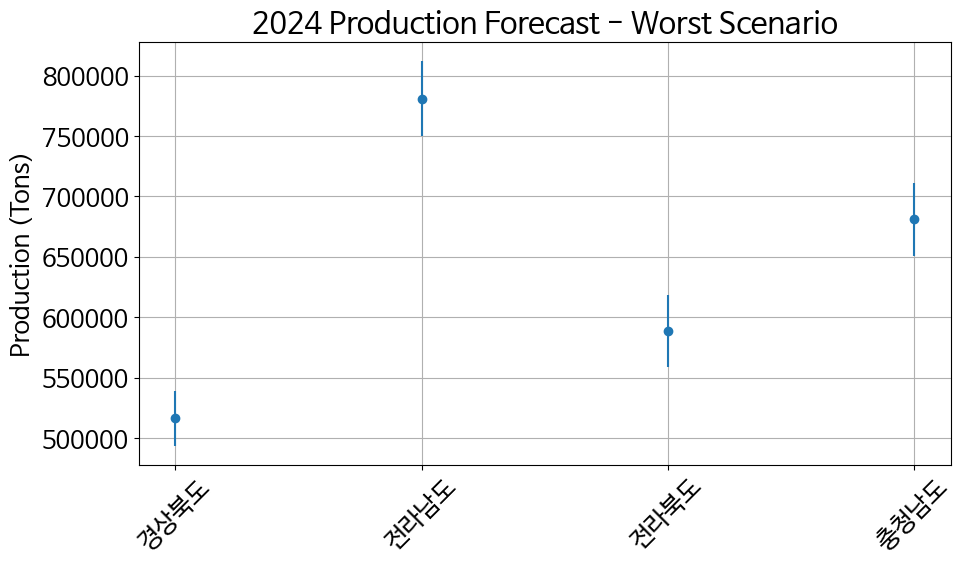


2024년 예측 (best 시나리오):
   행정구역   예측_생산량    신뢰구간_하한    신뢰구간_상한   재배면적(ha)  단위면적당_생산량   실제_생산량  변화율(%)
0  경상북도  515,507  492837.39  538176.29   89127.98       5.78  501,248    2.84
1  전라남도  771,347  740476.83  802217.17  146574.25       5.26  736,694    4.70
2  전라북도  577,260  547763.92  606756.46  105144.86       5.49  582,477   -0.90
3  충청남도  668,753  638711.73  698794.02  125087.66       5.35  726,989   -8.01


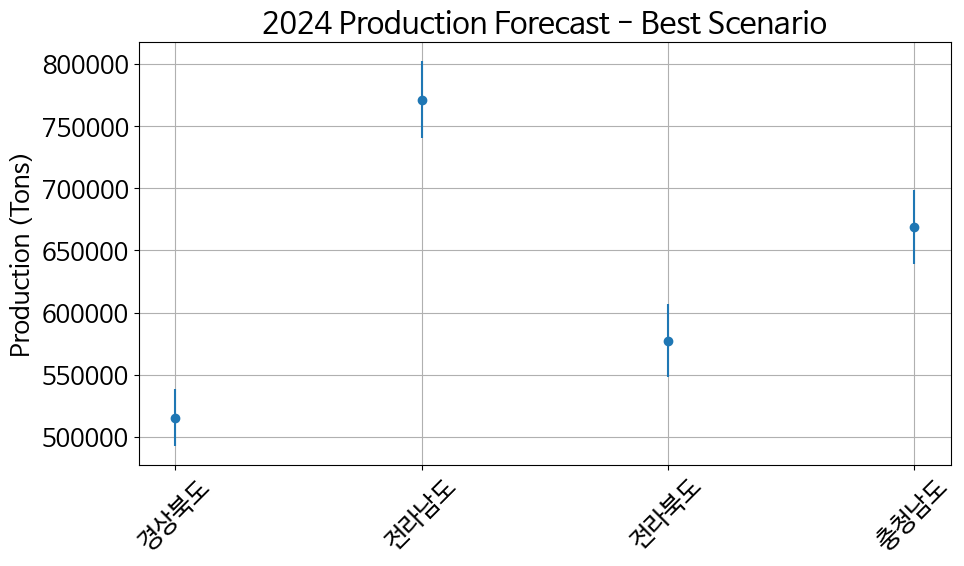


2025년 예측 (trend 시나리오):
   행정구역   예측_생산량    신뢰구간_하한    신뢰구간_상한   재배면적(ha)  단위면적당_생산량 2024년_예측  변화율(%)
0  경상북도  515,459  492789.71  538128.61   87269.72       5.91  515,459     0.0
1  전라남도  771,299  740429.15  802169.48  144339.04       5.34  771,299     0.0
2  전라북도  577,184  547687.86  606680.39  103132.81       5.60  577,184     0.0
3  충청남도  668,414  638372.98  698455.27  122891.46       5.44  668,414     0.0


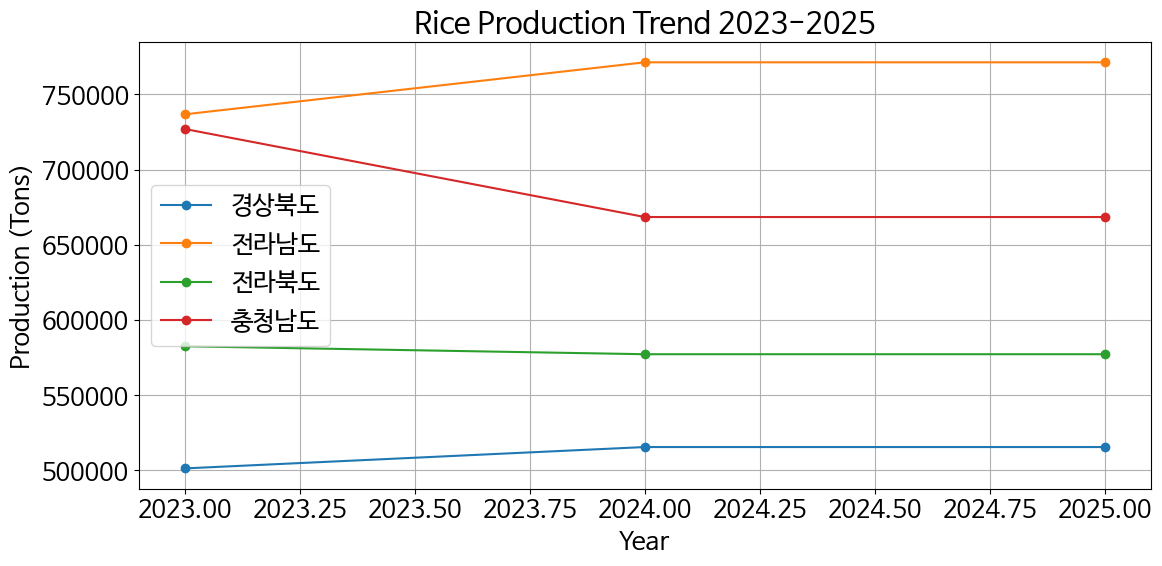

In [51]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

class RiceProductionPredictor:
    def __init__(self):
        """데이터 로드 및 초기화"""
        try:
            # 데이터 로드
            self.rice_data = pd.read_excel('/content/filtered_rice_production.xlsx')
            self.climate_annual = pd.read_csv('/content/filtered_climate_annual_data.csv')
            self.climate_monthly = pd.read_csv('/content/filtered_climate_monthly_data.csv')

            self.processed_data = None
            self.model = None
            self.scaler = StandardScaler()
            self.feature_columns = None

        except Exception as e:
            print(f"데이터 로드 중 오류 발생: {str(e)}")
            raise

    def prepare_data(self):
        """데이터 전처리"""
        try:
            # 연간 기후 데이터 처리 - 각 행정구역별 평균
            climate_annual_mean = self.climate_annual.groupby(['행정구역', '일시']).agg({
                '평균기온(°C)': 'mean',
                '합계 강수량(mm)': 'sum',
                '평균 상대습도(%)': 'mean',
                '합계 일조시간(hr)': 'mean'
            }).reset_index()

            # 월별 기후 데이터 처리
            self.climate_monthly['연도'] = self.climate_monthly['일시'].str.split('-').str[0].astype(int)
            self.climate_monthly['월'] = self.climate_monthly['일시'].str.split('-').str[1].astype(int)

            # 월별 데이터 피봇 테이블 생성 (한 번에 하나의 측정값만 처리)
            pivot_dfs = []
            measures = ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)', '합계 일조시간(hr)']

            for measure in measures:
                pivot_df = pd.pivot_table(
                    self.climate_monthly,
                    values=measure,
                    index=['행정구역', '연도'],
                    columns='월',
                    aggfunc='mean' if measure == '평균기온(°C)' or measure == '평균 상대습도(%)' else 'sum'
                ).reset_index()

                # 컬럼명 변경
                pivot_df.columns = [str(col) if isinstance(col, int) else col for col in pivot_df.columns]
                pivot_df.columns = [f"{measure}_{col}월" if col.isdigit() else col for col in pivot_df.columns]

                pivot_dfs.append(pivot_df)

            # 모든 피벗 테이블 병합
            climate_monthly_pivot = pivot_dfs[0]
            for df in pivot_dfs[1:]:
                climate_monthly_pivot = pd.merge(
                    climate_monthly_pivot,
                    df,
                    on=['행정구역', '연도'],
                    how='inner'
                )

            # 연도 컬럼명 변경
            climate_monthly_pivot = climate_monthly_pivot.rename(columns={'연도': '일시'})

            # 데이터 병합
            merged_data = pd.merge(
                self.rice_data,
                climate_annual_mean,
                on=['행정구역', '일시'],
                how='left'
            )

            self.processed_data = pd.merge(
                merged_data,
                climate_monthly_pivot,
                on=['행정구역', '일시'],
                how='left'
            )

            # 이전 연도 데이터 추가
            self.processed_data['이전년도_생산량'] = self.processed_data.groupby('행정구역')['생산량(톤)'].shift(1)
            self.processed_data['이전년도_재배면적'] = self.processed_data.groupby('행정구역')['재배면적(ha)'].shift(1)

            # 결측치 제거
            self.processed_data = self.processed_data.dropna()

            # 범주형 변수 처리
            self.processed_data = pd.get_dummies(self.processed_data, columns=['행정구역'], prefix='지역')

            return self.processed_data

        except Exception as e:
            print(f"데이터 전처리 중 오류 발생: {str(e)}")
            print("\n현재 데이터 상태:")
            print("기후 월별 데이터 shape:", self.climate_monthly.shape)
            print("기후 연간 데이터 shape:", climate_annual_mean.shape if 'climate_annual_mean' in locals() else "Not created")
            raise

    def train_model(self, target_year=2023):
          """모델 학습"""
          try:
              # 데이터 준비
              data = self.prepare_data()

              # 학습 데이터와 테스트 데이터 분리
              train_data = data[data['일시'] < target_year]
              test_data = data[data['일시'] == target_year]

              if len(test_data) == 0:
                  raise ValueError(f"{target_year}년 데이터가 없습니다.")

              # 특성과 타겟 분리
              self.feature_columns = [col for col in data.columns
                                    if col not in ['생산량(톤)', '일시']]
              X_train = train_data[self.feature_columns]
              y_train = train_data['생산량(톤)']
              X_test = test_data[self.feature_columns]
              y_test = test_data['생산량(톤)']

              # print("\n학습 데이터 크기:", X_train.shape)
              # print("테스트 데이터 크기:", X_test.shape)

              # 특성 스케일링
              X_train_scaled = self.scaler.fit_transform(X_train)
              X_test_scaled = self.scaler.transform(X_test)

              # 모델 학습
              self.model = XGBRegressor(
                  n_estimators=100,
                  learning_rate=0.1,
                  max_depth=5,
                  random_state=42
              )
              self.model.fit(X_train_scaled, y_train)

              # 예측 및 평가
              y_pred = self.model.predict(X_test_scaled)

              # 평가 지표 계산
              mse = mean_squared_error(y_test, y_pred)
              rmse = np.sqrt(mse)
              r2 = r2_score(y_test, y_pred)
              mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

              # 원본 지역명 복원
              region_columns = [col for col in test_data.columns if col.startswith('지역_')]
              region_mapping = test_data[region_columns].idxmax(axis=1).map(lambda x: x.replace('지역_', ''))

              # 결과 데이터프레임 생성
              results = pd.DataFrame({
                  '행정구역': region_mapping,
                  '실제_생산량': y_test,
                  '예측_생산량': y_pred,
                  '오차': y_pred - y_test,
                  '오차율(%)': ((y_pred - y_test) / y_test) * 100
              })

              # 특성 중요도 계산
              feature_importance = pd.DataFrame({
                  'feature': self.feature_columns,
                  'importance': self.model.feature_importances_
              }).sort_values('importance', ascending=False)

              return results, {'RMSE': rmse, 'R2': r2, 'MAPE': mape}, feature_importance

          except Exception as e:
              print(f"모델 학습 중 오류 발생: {str(e)}")
              raise

    def predict_future(self, future_year, scenario='trend'):
        """쌀 재배시기를 고려한 미래 생산량 예측"""
        try:
            if not self.model:
                raise ValueError("모델이 학습되지 않았습니다. 먼저 train_model을 실행하세요.")

            # 재배시기별 기후 변수 가중치 정의
            growing_seasons = {
                '육묘기': {
                    'months': [3, 4],  # 3-4월
                    'weight': 1.2,
                    'critical_vars': ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)']
                },
                '모내기': {
                    'months': [5],     # 5월
                    'weight': 1.5,
                    'critical_vars': ['평균기온(°C)', '합계 강수량(mm)']
                },
                '생육기': {
                    'months': [6, 7, 8],  # 6-8월
                    'weight': 1.3,
                    'critical_vars': ['평균기온(°C)', '합계 강수량(mm)', '합계 일조시간(hr)']
                },
                '출수기': {
                    'months': [8, 9],  # 8-9월
                    'weight': 1.4,
                    'critical_vars': ['평균기온(°C)', '합계 일조시간(hr)']
                },
                '등숙기': {
                    'months': [9, 10],  # 9-10월
                    'weight': 1.3,
                    'critical_vars': ['평균기온(°C)', '합계 일조시간(hr)', '평균 상대습도(%)']
                }
            }

            # 지역 목록 가져오기
            region_columns = [col for col in self.processed_data.columns if col.startswith('지역_')]
            regions = [col.replace('지역_', '') for col in region_columns]

            predictions = []

            for region in regions:
                # 해당 지역의 데이터
                region_mask = self.processed_data[f'지역_{region}'] == 1
                region_data = self.processed_data[region_mask].copy()
                latest_data = region_data.iloc[-1:].copy()

                if len(latest_data) == 0:
                    print(f"경고: {region}의 최근 데이터가 없습니다.")
                    continue

                latest_data['일시'] = future_year

                # 시나리오별 기후 데이터 처리
                if scenario == 'trend':
                    # 재배시기별로 기후변화 추세 분석 및 적용
                    for season, season_info in growing_seasons.items():
                        for var in season_info['critical_vars']:
                            # 해당 시기의 월별 컬럼 찾기
                            season_cols = [f"{var}_{m}월" for m in season_info['months']
                                        if f"{var}_{m}월" in region_data.columns]

                            for col in season_cols:
                                # 연간 추세 계산
                                years = region_data['일시'].values
                                values = region_data[col].values
                                trend = np.polyfit(years, values, deg=1)

                                # 추세를 반영한 미래값 예측 (가중치 적용)
                                projected_value = np.polyval(trend, future_year) * season_info['weight']
                                latest_data[col] = projected_value

                elif scenario == 'worst':
                    for season, season_info in growing_seasons.items():
                        for var in season_info['critical_vars']:
                            season_cols = [f"{var}_{m}월" for m in season_info['months']
                                        if f"{var}_{m}월" in region_data.columns]

                            for col in season_cols:
                                if '기온' in col:
                                    if any(m in col for m in ['6', '7', '8']):  # 생육기 고온
                                        latest_data[col] = region_data[col].max() * 1.2
                                    else:
                                        latest_data[col] = region_data[col].mean()
                                elif '강수량' in col:
                                    if any(m in col for m in ['5']):  # 모내기철 가뭄
                                        latest_data[col] = region_data[col].min() * 0.8
                                    elif any(m in col for m in ['9']):  # 수확기 강우
                                        latest_data[col] = region_data[col].max() * 1.3
                                    else:
                                        latest_data[col] = region_data[col].mean()
                                else:
                                    latest_data[col] = region_data[col].quantile(0.1)

                elif scenario == 'best':
                    # 과거 최고 수확량 년도의 기후조건 활용
                    best_year = region_data.loc[region_data['생산량(톤)'].idxmax(), '일시']
                    best_climate = region_data[region_data['일시'] == best_year].copy()

                    for season, season_info in growing_seasons.items():
                        for var in season_info['critical_vars']:
                            season_cols = [f"{var}_{m}월" for m in season_info['months']
                                        if f"{var}_{m}월" in region_data.columns]

                            for col in season_cols:
                                latest_data[col] = best_climate[col].iloc[0] * season_info['weight']

                else:  # 'average' scenario
                    # 최근 5년 평균 기후 데이터에 시기별 가중치 적용
                    recent_data = region_data.tail(5)
                    for season, season_info in growing_seasons.items():
                        for var in season_info['critical_vars']:
                            season_cols = [f"{var}_{m}월" for m in season_info['months']
                                        if f"{var}_{m}월" in region_data.columns]

                            for col in season_cols:
                                latest_data[col] = recent_data[col].mean() * season_info['weight']

                # 재배면적 추세 반영
                years = region_data['일시'].values
                areas = region_data['재배면적(ha)'].values
                area_trend = np.polyfit(years, areas, deg=1)
                projected_area = np.polyval(area_trend, future_year)
                latest_data['재배면적(ha)'] = projected_area

                # 이전 연도 데이터 업데이트
                latest_data['이전년도_생산량'] = region_data.iloc[-1]['생산량(톤)']
                latest_data['이전년도_재배면적'] = region_data.iloc[-1]['재배면적(ha)']

                # 예측을 위한 특성 선택
                X_future = latest_data[self.feature_columns]

                # 스케일링 및 예측
                X_future_scaled = self.scaler.transform(X_future)
                pred = self.model.predict(X_future_scaled)[0]

                # 95% 신뢰구간 계산
                pred_std = np.std(region_data['생산량(톤)']) / np.sqrt(len(region_data))
                confidence_interval = 1.96 * pred_std

                predictions.append({
                    '행정구역': region,
                    '예측_생산량': pred,
                    '신뢰구간_하한': max(0, pred - confidence_interval),
                    '신뢰구간_상한': pred + confidence_interval,
                    '재배면적(ha)': latest_data['재배면적(ha)'].iloc[0]
                })

            results_df = pd.DataFrame(predictions)
            results_df['단위면적당_생산량'] = results_df['예측_생산량'] / results_df['재배면적(ha)']

            return results_df

        except Exception as e:
            print(f"미래 예측 중 오류 발생: {str(e)}")
            raise

    def evaluate_predictions(self, y_true, y_pred):
        """예측 결과에 대한 다양한 평가 지표 계산"""
        try:
            # 기본 평가 지표
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

            # Adjusted R2 계산
            n = len(y_true)
            p = len(self.feature_columns)
            adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

            # 예측 정확도 분석
            errors = y_true - y_pred
            mean_error = np.mean(errors)
            std_error = np.std(errors)

            # 95% 신뢰구간
            confidence_interval = 1.96 * std_error / np.sqrt(n)

            # 정규성 검정은 샘플 수가 8개 이상일 때만 수행
            if len(y_true) >= 8:
                _, normality_p_value = stats.normaltest(errors)
            else:
                # 샘플 수가 적을 때는 정규성 가정
                normality_p_value = 1.0

            return {
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2,
                'Adjusted_R2': adjusted_r2,
                'MAPE': mape,
                'Mean_Error': mean_error,
                'Std_Error': std_error,
                'Confidence_Interval': confidence_interval,
                'Error_Normality_p_value': normality_p_value,
                'Sample_Size': len(y_true)
            }

        except Exception as e:
            print(f"평가 지표 계산 중 오류 발생: {str(e)}")
            raise

    def plot_growing_season_analysis(self, region=None):
        """생육시기별 기후 영향 시각화"""
        plt.style.use('seaborn')

        # 생육시기 정의
        growing_seasons = {
            '육묘기': [3, 4],
            '모내기': [5],
            '생육기': [6, 7, 8],
            '출수기': [8, 9],
            '등숙기': [9, 10]
        }

        # 기후 변수
        climate_vars = ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)', '합계 일조시간(hr)']

        fig = plt.figure(figsize=(20, 10))
        gs = fig.add_gridspec(2, 2)

        # 1. 생육시기별 기후요소 영향도 히트맵
        ax1 = fig.add_subplot(gs[0, 0])
        impact_data = {}

        for season, months in growing_seasons.items():
            season_impact = {}
            for var in climate_vars:
                cols = [f"{var}_{m}월" for m in months]
                correlation = np.abs(self.processed_data[cols].corrwith(self.processed_data['생산량(톤)'])).mean()
                season_impact[var] = correlation
            impact_data[season] = season_impact

        impact_df = pd.DataFrame(impact_data)
        sns.heatmap(impact_df, annot=True, cmap='YlOrRd', ax=ax1)
        ax1.set_title('생육시기별 기후요소 영향도')

        # 2. 월별 기온 변화 추이
        ax2 = fig.add_subplot(gs[0, 1])
        temp_cols = [col for col in self.processed_data.columns if '평균기온(°C)' in col and '월' in col]

        if region:
            region_data = self.processed_data[self.processed_data[f'지역_{region}'] == 1]
        else:
            region_data = self.processed_data

        months = range(1, 13)
        years = region_data['일시'].unique()[-5:]  # 최근 5년

        for year in years:
            year_data = region_data[region_data['일시'] == year]
            temps = [year_data[f'평균기온(°C)_{m}월'].mean() for m in months]
            ax2.plot(months, temps, marker='o', label=str(year))

        ax2.set_xticks(months)
        ax2.set_xlabel('월')
        ax2.set_ylabel('평균 기온(°C)')
        ax2.set_title('월별 기온 변화 추이 (최근 5년)')
        ax2.legend()
        ax2.grid(True)

        # 3. 강수량 분포 boxplot
        ax3 = fig.add_subplot(gs[1, 0])
        rain_cols = [col for col in self.processed_data.columns if '강수량' in col and '월' in col]
        rain_data = region_data[rain_cols].melt()
        sns.boxplot(x='variable', y='value', data=rain_data, ax=ax3)
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
        ax3.set_title('월별 강수량 분포')

        # 4. 일조시간과 생산량의 관계
        ax4 = fig.add_subplot(gs[1, 1])
        sun_cols = [col for col in self.processed_data.columns if '일조시간' in col and '월' in col]
        total_sun = region_data[sun_cols].sum(axis=1)
        ax4.scatter(total_sun, region_data['생산량(톤)'])
        ax4.set_xlabel('연간 총 일조시간')
        ax4.set_ylabel('생산량(톤)')
        ax4.set_title('일조시간과 생산량의 관계')

        plt.tight_layout()
        plt.show()

    def plot_prediction_results(self, comparison_2024, predictions_2025, results_2023):
        """예측 결과 시각화"""
        plt.style.use('seaborn')

        # 1. 시나리오별 예측 비교
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))

        # 바 차트로 시나리오별 예측량 비교
        scenarios = ['trend', 'average', 'worst', 'best']
        colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f']

        for i, scenario in enumerate(scenarios):
            ax = axes[i//2, i%2]
            comparison = comparison_2024[scenario]

            x = np.arange(len(comparison['행정구역']))
            width = 0.35

            ax.bar(x - width/2, comparison['실제_생산량'], width, label='실제 생산량', color='gray', alpha=0.5)
            ax.bar(x + width/2, comparison['예측_생산량'], width, label='예측 생산량', color=colors[i])

            # 신뢰구간 표시
            ax.errorbar(x + width/2, comparison['예측_생산량'],
                      yerr=[comparison['예측_생산량'] - comparison['신뢰구간_하한'],
                            comparison['신뢰구간_상한'] - comparison['예측_생산량']],
                      fmt='none', color='black', capsize=5)

            ax.set_xticks(x)
            ax.set_xticklabels(comparison['행정구역'])
            ax.set_title(f'{scenario.capitalize()} 시나리오 예측 결과')
            ax.legend()

        plt.tight_layout()
        plt.show()

        # 2. 2023-2025 추세 분석
        plt.figure(figsize=(12, 8))

        for region in results_2023['행정구역'].unique():
            years = [2023, 2024, 2025]
            values = [
                results_2023[results_2023['행정구역'] == region]['실제_생산량'].iloc[0],
                comparison_2024['trend'][comparison_2024['trend']['행정구역'] == region]['예측_생산량'].iloc[0],
                predictions_2025[predictions_2025['행정구역'] == region]['예측_생산량'].iloc[0]
            ]
            plt.plot(years, values, marker='o', linewidth=2, markersize=8, label=region)

        plt.title('쌀 생산량 추세 분석 (2023-2025)', fontsize=14)
        plt.xlabel('연도', fontsize=12)
        plt.ylabel('생산량(톤)', fontsize=12)
        plt.grid(True)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()

        # 3. 지역별 단위면적당 생산량 비교
        plt.figure(figsize=(10, 6))
        for scenario in scenarios:
            data = comparison_2024[scenario]
            plt.plot(data['행정구역'], data['단위면적당_생산량'],
                    marker='o', label=scenario.capitalize())

        plt.title('시나리오별 단위면적당 생산량 비교', fontsize=14)
        plt.xlabel('지역', fontsize=12)
        plt.ylabel('단위면적당 생산량(톤/ha)', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()



def main():
    try:
        # 예측기 인스턴스 생성
        print("="*50)
        print("쌀 생산량 예측 모델 초기화")
        print("="*50)
        predictor = RiceProductionPredictor()

        # 2023년 예측 및 평가
        #
        print("\n2023년 쌀 생산량 예측 시작...")
        results_2023, metrics, feature_importance = predictor.train_model(target_year=2023)

        # 상세 평가 지표 계산
        detailed_metrics = predictor.evaluate_predictions(
            results_2023['실제_생산량'],
            results_2023['예측_생산량']
        )

        # 결과 출력
        print("\n2023년 예측 결과:")
        results_display = results_2023.copy()
        # 천 단위 구분기호 추가
        results_display['실제_생산량'] = results_display['실제_생산량'].apply(lambda x: f"{x:,.0f}")
        results_display['예측_생산량'] = results_display['예측_생산량'].apply(lambda x: f"{x:,.0f}")
        print(results_display)

        print("\n모델 평가 지표:")
        metrics_df = pd.DataFrame([detailed_metrics]).round(4)
        print(metrics_df)

        print("\n오차의 정규성 검정 결과:")
        print(f"p-value: {detailed_metrics['Error_Normality_p_value']:.4f}")
        if detailed_metrics['Error_Normality_p_value'] > 0.05:
            print("오차가 정규분포를 따릅니다 (신뢰할 만한 예측)")
        else:
            print("오차가 정규분포를 따르지 않습니다 (예측에 편향이 있을 수 있음)")

        # print("\n주요 영향 특성 (상위 10개):")
        # print(feature_importance.head(10))

        # # 특성 중요도 시각화
        # plt.figure(figsize=(12, 6))
        # sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
        # plt.title('Top 10 Important Features')
        # plt.xlabel('Feature Importance')
        # plt.tight_layout()
        # plt.show()

        # 미래 예측
        if detailed_metrics['R2'] > 0.7:
            print("\n미래 생산량 예측 시작...")

            # 각 시나리오별 2024년 예측
            scenarios = ['trend', 'average', 'worst', 'best']
            predictions_2024 = {}

            for scenario in scenarios:
                predictions_2024[scenario] = predictor.predict_future(2024, scenario=scenario)
                comparison = pd.merge(
                    predictions_2024[scenario],
                    results_2023[['행정구역', '실제_생산량']].groupby('행정구역').first(),
                    on='행정구역'
                )
                comparison['변화율(%)'] = (
                    (comparison['예측_생산량'] - comparison['실제_생산량'])
                    / comparison['실제_생산량'] * 100
                )

                print(f"\n2024년 예측 ({scenario} 시나리오):")
                comparison_display = comparison.copy()
                # 천 단위 구분기호 추가
                comparison_display['예측_생산량'] = comparison_display['예측_생산량'].apply(lambda x: f"{x:,.0f}")
                comparison_display['실제_생산량'] = comparison_display['실제_생산량'].apply(lambda x: f"{x:,.0f}")
                print(comparison_display.round(2))

                # 신뢰구간 시각화
                plt.figure(figsize=(10, 6))
                plt.errorbar(
                    comparison['행정구역'],
                    comparison['예측_생산량'],
                    yerr=[
                        comparison['예측_생산량'] - comparison['신뢰구간_하한'],
                        comparison['신뢰구간_상한'] - comparison['예측_생산량']
                    ],
                    fmt='o'
                )
                plt.title(f'2024 Production Forecast - {scenario.capitalize()} Scenario')
                plt.ylabel('Production (Tons)')
                plt.xticks(rotation=45)
                plt.grid(True)
                plt.tight_layout()
                plt.show()

            # 2025년 예측 (trend 시나리오)
            predictions_2025 = predictor.predict_future(2025, scenario='trend')
            comparison_2025 = pd.merge(
                predictions_2025,
                predictions_2024['trend'][['행정구역', '예측_생산량']].rename(
                    columns={'예측_생산량': '2024년_예측'}
                ),
                on='행정구역'
            )
            comparison_2025['변화율(%)'] = (
                (comparison_2025['예측_생산량'] - comparison_2025['2024년_예측'])
                / comparison_2025['2024년_예측'] * 100
            )

            print("\n2025년 예측 (trend 시나리오):")
            comparison_display = comparison_2025.copy()
            # 천 단위 구분기호 추가
            comparison_display['예측_생산량'] = comparison_display['예측_생산량'].apply(lambda x: f"{x:,.0f}")
            comparison_display['2024년_예측'] = comparison_display['2024년_예측'].apply(lambda x: f"{x:,.0f}")
            print(comparison_display.round(2))

            # 2023-2025 추세 시각화
            plt.figure(figsize=(12, 6))
            for region in results_2023['행정구역'].unique():
                years = [2023, 2024, 2025]
                values = [
                    results_2023[results_2023['행정구역'] == region]['실제_생산량'].iloc[0],
                    predictions_2024['trend'][predictions_2024['trend']['행정구역'] == region]['예측_생산량'].iloc[0],
                    predictions_2025[predictions_2025['행정구역'] == region]['예측_생산량'].iloc[0]
                ]
                plt.plot(years, values, marker='o', label=region)

            plt.title('Rice Production Trend 2023-2025')
            plt.xlabel('Year')
            plt.ylabel('Production (Tons)')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        else:
            print("\n모델의 정확도가 낮아 미래 예측을 수행하지 않습니다.")

    except Exception as e:
        print(f"\n프로그램 실행 중 오류 발생: {str(e)}")
        raise

if __name__ == "__main__":
    main()